In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
data_dir = "./Ex06_images/Brain_Tumor_Dataset"

Mounted at /content/gdrive


# Deep Learning for Brain Tumor Detection

In [ ]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## Load data

This code loads 2D images of healthy brains and brains containing tumors using a dataloader.

In [ ]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, path

In [ ]:
# Data augmentation and normalization for training

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=6) for x in ['train', 'val', 'test']}

# Train 143 (56,5%), Val 62 (24,5%), Test 48 (19%)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
print(dataset_sizes)

{'train': 143, 'val': 62, 'test': 48}


# Viewing some images (one batch)

Batch of training data


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


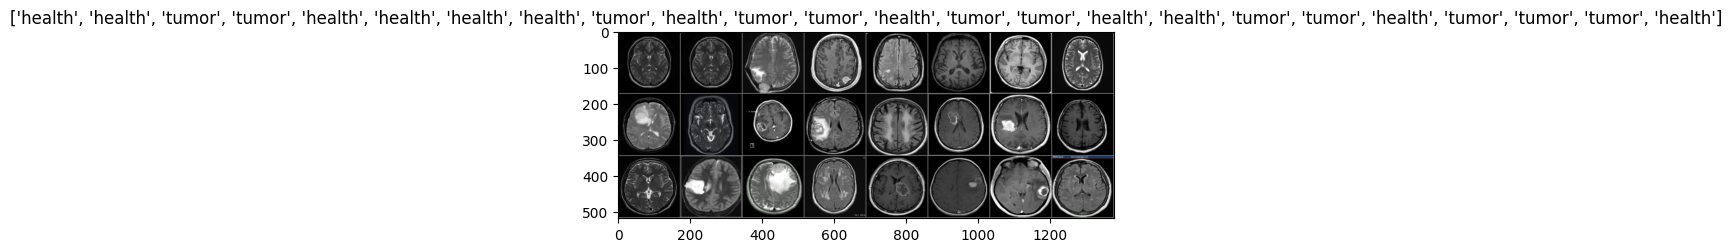

Batch of validation data


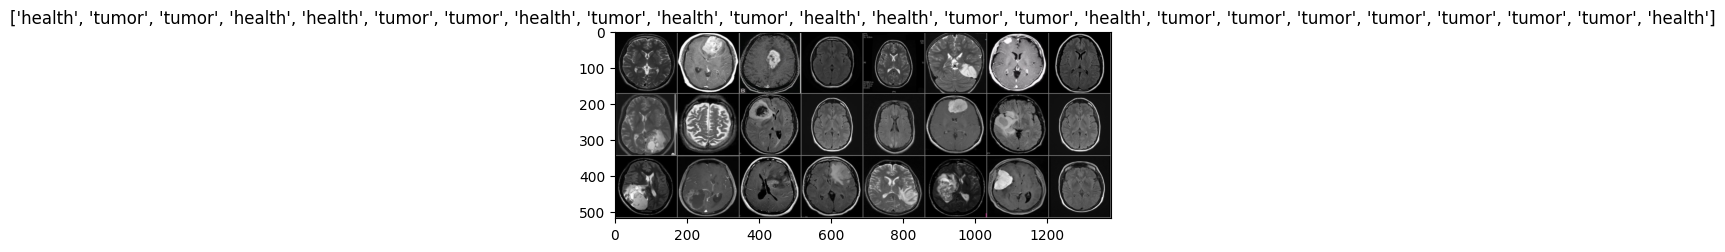

Batch of test data


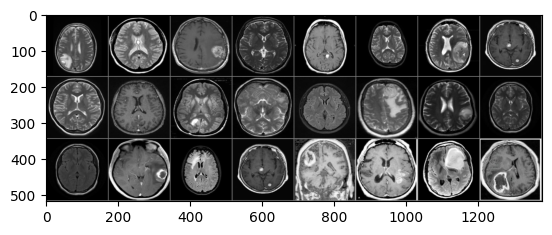

('gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex05/Brain_Tumor_Dataset/test/test/test27.jpg', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex05/Brain_Tumor_Dataset/test/test/test36.JPG', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex05/Brain_Tumor_Dataset/test/test/test45.JPG', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex05/Brain_Tumor_Dataset/test/test/test14.jpg', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex05/Brain_Tumor_Dataset/test/test/test3.jpg', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex05/Brain_Tumor_Dataset/test/test/test12.jpg', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex05/Brain_Tumor_Dataset/test/test/test28.jpg', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex05/Brain_Tumor_Dataset/test/test/test4.jpg', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex05/Brain_Tumor_Dataset/test/test/test16.jpg', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex05/Brain_Tumor_Dataset/test/test/test7.JPG', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex05/Brain_Tumor_Dataset/test/test/test44.JPG', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex05/B

In [ ]:
#visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes, _ = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


print('Batch of validation data')
inputs, classes, _ = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



print('Batch of test data')
inputs, _, paths = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

print(paths)

# Training the model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'train':
                LOSS_train.append(epoch_loss)
                ACC_train.append(epoch_acc)
            if phase == 'val':
                LOSS_val.append(epoch_loss)
                ACC_val.append(epoch_acc)
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


# Testing the model

In [ ]:
def test_model(model, num_images=48):
    was_training = model.training
    model.eval()
    images_so_far = 0
    

    with torch.no_grad():
        for i, (inputs, _, paths) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                fig = plt.figure(figsize=(50, 50))
                plt.tight_layout() 
                plt.subplot(num_images, 1, images_so_far)
                plt.axis('off')
                print('path: {} / predicted: {}'.format(paths[j].split('/')[7], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Experiment

In the code below, a model based on [Resnet-18](https://pytorch.org/vision/master/models/generated/torchvision.models.resnet18.html) is created. It is trained **without transfer learning** and with a random initialization of the weights.

In [ ]:
model_ft_randstart = models.resnet18(pretrained=False)
num_ftrs = model_ft_randstart.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_randstart.fc = nn.Linear(num_ftrs, 2)

model_ft_randstart = model_ft_randstart.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_randstart = optim.SGD(model_ft_randstart.parameters(), lr=0.0008, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=200, gamma=0.5)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In the cell below, you can view all the layers that make up the model and their parameters.

In [ ]:
model_ft_randstart

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The cell below presents a summary of the provided PyTorch model, similar to the Tensorflow API model.summary(). Summary information includes: layer names, input/output shapes, kernel shape, number of parameters, number of operations (Mult-Adds), and whether the layer is trainable. More information is available in the [Torchinfo](https://github.com/TylerYep/torchinfo) repository.


In [ ]:
summary(model_ft_randstart, (3, 170, 170))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 85, 85]           9,408
       BatchNorm2d-2           [-1, 64, 85, 85]             128
              ReLU-3           [-1, 64, 85, 85]               0
         MaxPool2d-4           [-1, 64, 43, 43]               0
            Conv2d-5           [-1, 64, 43, 43]          36,864
       BatchNorm2d-6           [-1, 64, 43, 43]             128
              ReLU-7           [-1, 64, 43, 43]               0
            Conv2d-8           [-1, 64, 43, 43]          36,864
       BatchNorm2d-9           [-1, 64, 43, 43]             128
             ReLU-10           [-1, 64, 43, 43]               0
       BasicBlock-11           [-1, 64, 43, 43]               0
           Conv2d-12           [-1, 64, 43, 43]          36,864
      BatchNorm2d-13           [-1, 64, 43, 43]             128
             ReLU-14           [-1, 64,

The cell below trains the model using the **train_model** function for 10 epochs.

In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_ft_randstart = train_model(model_ft_randstart, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/199
----------


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6695 Acc: 0.5944
val Loss: 0.6560 Acc: 0.6613

Epoch 1/199
----------
train Loss: 0.6671 Acc: 0.6294
val Loss: 0.6421 Acc: 0.6613

Epoch 2/199
----------
train Loss: 0.6439 Acc: 0.6643
val Loss: 0.6643 Acc: 0.6613

Epoch 3/199
----------
train Loss: 0.6177 Acc: 0.6923
val Loss: 0.6277 Acc: 0.6613

Epoch 4/199
----------
train Loss: 0.6049 Acc: 0.6294
val Loss: 0.6079 Acc: 0.6613

Epoch 5/199
----------
train Loss: 0.5533 Acc: 0.7692
val Loss: 0.6043 Acc: 0.7097

Epoch 6/199
----------
train Loss: 0.5549 Acc: 0.7622
val Loss: 0.5719 Acc: 0.6613

Epoch 7/199
----------
train Loss: 0.5162 Acc: 0.7692
val Loss: 0.5490 Acc: 0.6935

Epoch 8/199
----------
train Loss: 0.4987 Acc: 0.7832
val Loss: 0.5311 Acc: 0.6935

Epoch 9/199
----------
train Loss: 0.4624 Acc: 0.8252


KeyboardInterrupt: ignored

The cell below performs model prediction tests using the **test_model** function

path: test43.JPG / predicted: tumor


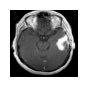

path: test11.jpg / predicted: health


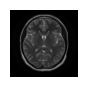

path: test17.jpeg / predicted: health


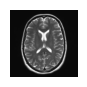

path: test4.jpg / predicted: tumor


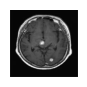

path: test23.jpeg / predicted: health


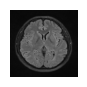

path: test19.png / predicted: tumor


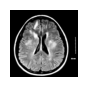

path: test9.JPG / predicted: tumor


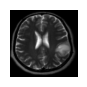

path: test33.JPG / predicted: health


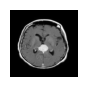

path: test48.JPG / predicted: tumor


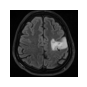

path: test30.JPG / predicted: tumor


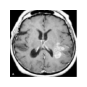

path: test40.JPG / predicted: tumor


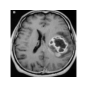

path: test21.jpg / predicted: health


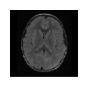

path: test18.jpg / predicted: tumor


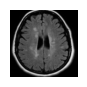

path: test13.jpg / predicted: health


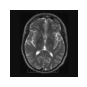

path: test41.jpg / predicted: tumor


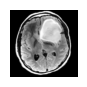

path: test32.JPG / predicted: tumor


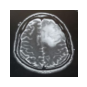

path: test7.JPG / predicted: tumor


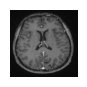

path: test25.jpg / predicted: tumor


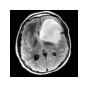

path: test37.JPG / predicted: tumor


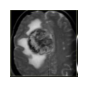

path: test20.jpg / predicted: health


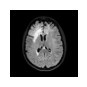

path: test16.jpg / predicted: tumor


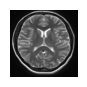

path: test5.jpg / predicted: tumor


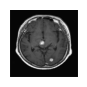

path: test27.jpg / predicted: health


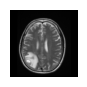

path: test45.JPG / predicted: tumor


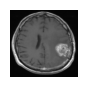

path: test1.jpg / predicted: tumor


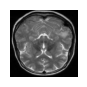

path: test28.jpg / predicted: tumor


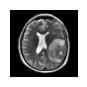

path: test38.JPG / predicted: tumor


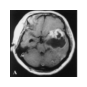

path: test3.jpg / predicted: tumor


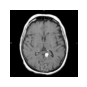

path: test35.JPG / predicted: tumor


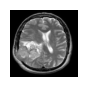

path: test22.jpg / predicted: health


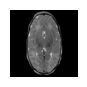

path: test44.JPG / predicted: tumor


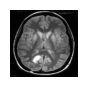

path: test6.JPG / predicted: tumor


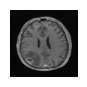

path: test10.JPG / predicted: tumor


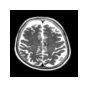

path: test34.JPG / predicted: tumor


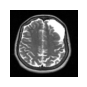

path: test29.JPG / predicted: tumor


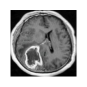

path: test36.JPG / predicted: tumor


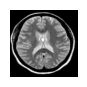

path: test31.JPG / predicted: tumor


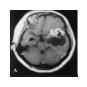

path: test26.jpg / predicted: tumor


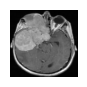

path: test2.jpg / predicted: tumor


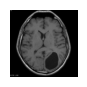

path: test42.jpg / predicted: tumor


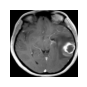

path: test15.jpeg / predicted: health


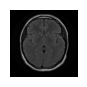

path: test24.jpg / predicted: tumor


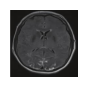

path: test39.JPG / predicted: tumor


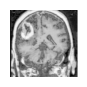

path: test14.jpg / predicted: health


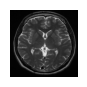

path: test12.jpg / predicted: health


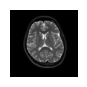

path: test46.JPG / predicted: tumor


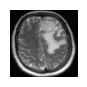

path: test8.jpg / predicted: tumor


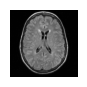

path: test47.JPG / predicted: tumor


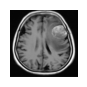

In [ ]:
test_model(model_ft_randstart)

# Viewing model predictions

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels, paths) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('path:{} predicted: {}'.format(paths[j].split('/')[7], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

The cell below performs model prediction tests using the **visualize_model** function

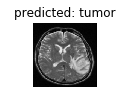

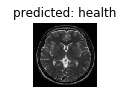

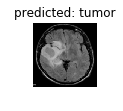

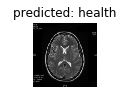

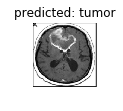

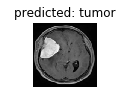

In [ ]:
visualize_model(model_ft_randstart)

### Experiment 2

**Finetuning:** Instead of random initialization, train and test the model using the same model (Resnet-18) initializing it with a pre-trained network.

Check the information available for the model [Resnet-18](https://pytorch.org/vision/master/models/generated/torchvision.models.resnet18.html) and about using [pre-trained models](https ://pytorch.org/vision/stable/models.html).

In [ ]:
# Your code here

### Experiment 3

Freeze the initialized model weights with a pre-trained network, with the exception of the last fully connected layer. This last layer must be replaced with a new layer. This new layer must be initialized with random weights and only this layer must be trained. Train and test this model.

In [ ]:
# Your code here

### Challenge

Try improving one of the previous models to get better accuracy with the test data.

Format for delivering the file with test predictions: .txt file with name "Ex06_N_RA.txt" (Ex: Ex06_000000.txt) containing, on each line: file name and prediction. See attached example.txt file.


Suggestions:
- Apply data augmentation to training, validation and test data.

- Use a tool to monitor and visualize training and validation curves (loss and accuracy). For example: [Neptune](https://neptune.ai) or [Wandb](https://wandb.ai/). Compare the different model versions used.

- The Optimizer, Learning-Rate, Number of Epochs, Batch Size, etc. hyperparameters can be modified.

# References

- [Resnet-18](https://pytorch.org/vision/master/models/generated/torchvision.models.resnet18.html)
- [Torchinfo](https://github.com/TylerYep/torchinfo).
- [Pytorch - Pre-trained models](https://pytorch.org/vision/stable/models.html).
- [Neptune](https://neptune.ai)
- [Wandb](https://wandb.ai/).